In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [3]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# Preparation of SAAS data
df.columns = [col.lower() for col in df]

In [5]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [6]:
# Changing subscription_type and amount to correct type (int)
df.subscription_type = df.subscription_type.astype(int)
df.amount = df.amount.astype(int)

In [7]:
# Setting datetime as index
df = df.set_index('month_invoiced')

<AxesSubplot:xlabel='month_invoiced'>

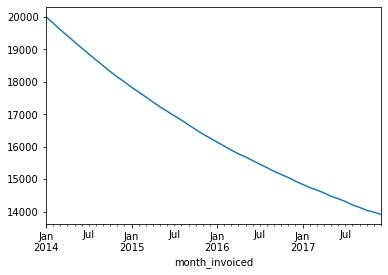

In [8]:
# How many observations /month?
df.resample('M').size().plot()


[Text(0.5, 1.0, 'Revenue over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

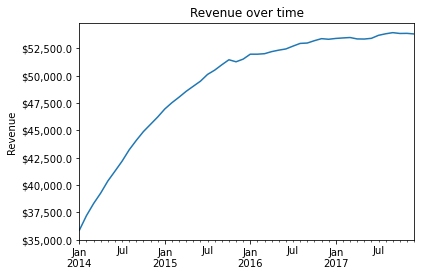

In [10]:
# Monthly revenue over time
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue over time', ylabel='Revenue', xlabel='')

In [11]:
# Focusing on revenue by month
df = df.resample('M')[['amount']].sum()

### For splitting:
1. We will use the training proportion method to split.
1. Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
1. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
1. Return train and test dataframes.

In [12]:
int(len(df) * .5)

24

In [13]:
# setting train to 50% of total
train_s = int(len(df) * .5)
train_s

24

In [14]:
# validate to 30%
validate_s = int(len(df) * .3)

In [15]:
# test to remainder
test_s = int(len(df) - train_s - validate_s)
test_s

10

In [16]:
# Set end for validate
validate_end_index = train_s + validate_s

In [17]:
# Using values to split data
train = df[:train_s]
validate = df[train_s:validate_end_index]
test = df[validate_end_index:]

In [18]:
train.columns

Index(['amount'], dtype='object')

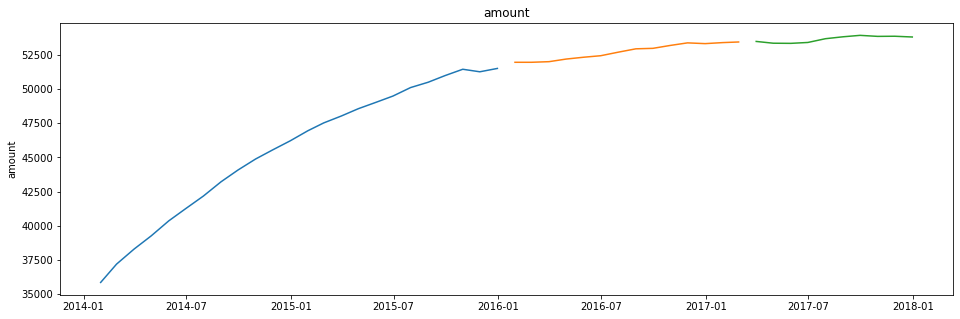

In [19]:
for col in train.columns:
    plt.figure(figsize=(16,5))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [20]:
# Useful functions for evaluation

In [21]:
# Compute the Mean Squared Error and the Root Mean Squared Error
def evaluate(target_var):
    '''
    Take actual values of target_var from validate, and predicted values stoared in yhat_df, 
    compute the rmse, rounding to 0 decimal places. Returns rmse.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [31]:
# Use evaluate function and also plot train and test values with predicted values in order to compare performance
def plot_and_eval(target_var):
    '''
    Takes in target var name (str), returns a plot of values of train for that var, and the predicted values from yhat_df.
    Labels the rmse.
    '''
    plt.figure(figsize=(13,5))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [32]:
# Function that stores the rmse so that we can compare them at the end
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [33]:
# Creating an empty df
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Forecasting:
'Predicting' time series data
1. Last Observed Value: Future will like like the now.
2. Simple Average: Future will look, on average, like history.
3. Moving Average: Future will look, on average, like recent history.
4. Holt's Linear Trend. 
5. Previous Cycle.

#### Last Observed Value

In [34]:
train['amount'][-1:][0]

51505

In [35]:
# Take last item from amount and assign to var
amount = train['amount'][-1:][0]

In [36]:
yhat_df = pd.DataFrame({'amount': [amount]},
                      index=validate.index)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505
2016-02-29,51505
2016-03-31,51505
2016-04-30,51505
2016-05-31,51505


In [37]:
yhat_df.describe()

,amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


In [38]:
# Notice that every predicted value is the same

amount -- RMSE: 1343


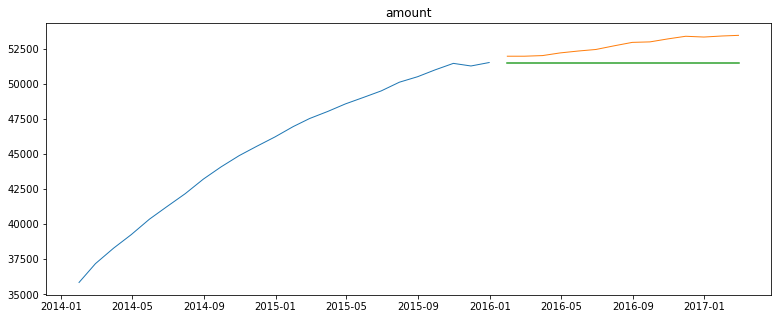

In [39]:
# Plotting actual vs predicted
plot_and_eval('amount')

amount -- RMSE: 1343


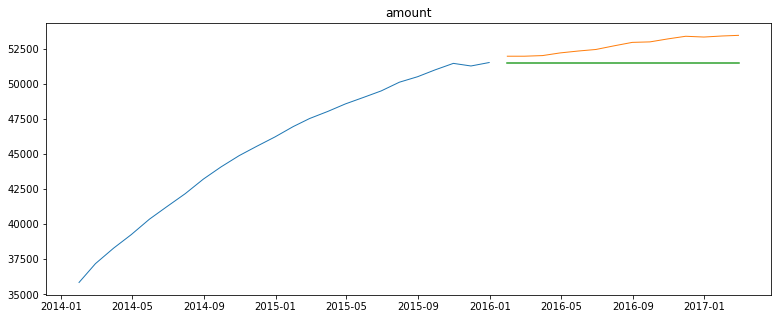

In [40]:
for col in train.columns:
    plot_and_eval(col)

In [41]:
# Evaluation w/ MSE and RMSE
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                            target_var = col)
eval_df

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_1600/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


#### Simple Average

In [42]:
amount = round(train['amount'].mean(), 2)

In [43]:
# Apply predictions to observations
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=validate.index)
    return yhat_df

In [44]:
yhat_df = make_predictions(amount)

amount -- RMSE: 7181


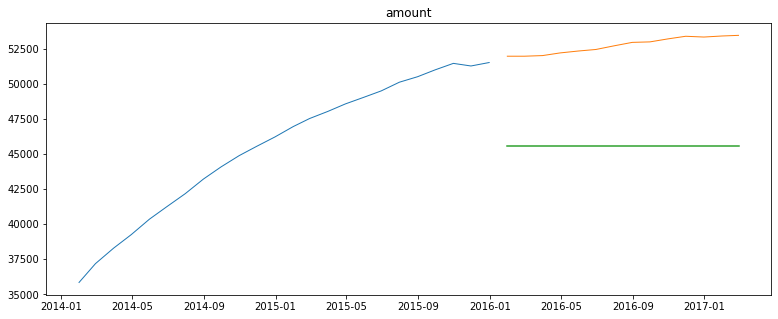

In [45]:
# Plotting actual vs predicted values
for col in train.columns:
    plot_and_eval(col)

In [46]:
# Evaluate using MSE and RMSE, add to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_avg',
                            target_var = col)
eval_df

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_1600/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_avg,amount,7181.0


#### Moving Average

In [47]:
# Using example of 3 month average to forecast

In [48]:
period = 3
train['amount'].rolling(period).mean()[-1]

51403.333333333336

In [ ]:
period = 3
# Take the 90 day rolling avg, then take the last element and that will be the one that is used to 